# スタイルベクトルをもっと詳しく作りたい人向け

JVNVコーパスの例を使いながらクラスタリングをいろいろいじったり、また正解ラベルからベクトルを作りたい人向けです。
もっといろいろ足したりいろんなスタイルベクトルを作って遊べると思います。
ある程度慣れている人向けです。

例では[JVNVコーパス](https://sites.google.com/site/shinnosuketakamichi/research-topics/jvnv_corpus)のjvnv-M1を使います。

## そもそもスタイルベクトルとは
[この話者識別モデル](https://huggingface.co/pyannote/wespeaker-voxceleb-resnet34-LM)を使って生成された、1つの音声ファイルにつき256次元のベクトルです。話者識別用のものですが、感情や声音の特徴も含まれているので、スタイルベクトルとして使えます。

このStyle Bert-VITS2では、この256次元のベクトルをエンコーダに注入して学習しているので、推論時にそのベクトルを入れてあげる必要があります。ある感情を強く表していると思われるベクトルを入れると、その感情を強く表現した音声が生成される、という仕組みです。

もともとが話者識別用なので、「この感情はこのベクトル」のような普遍的なスタイルベクトルは使えません。なのでこのように、いちいちデータセットごとにベクトルを作る必要があります。

## モデルを使うために必要なもの
- `model_assets/{model_name}/model_name.safetensors`: 学習の結果出力されるモデルファイル。これは自動的にこの場所に置かれ、スタイルベクトルとは全く独立。
- `model_assets/{model_name}/style_vectors.npy`: スタイルベクトルのnumpyファイル。ベクトルをいくつかいれる。
- `model_assets/{model_name}/config.json`: モデルの設定ファイル（学習前準備で自動的に生成されるはず）。これの以下の項目を設定。
```json
{
    "data": {
        "num_styles": 4, // スタイルベクトルの数
        "style2id": { // スタイルベクトルの名前とidの対応
            "Neutral": 0,
            "Angry": 1,
            "Happy": 2,
            "Sad": 3
        }
    }
}
```
ここでidは0から始まる整数で、スタイルベクトルのnumpyファイルの何番目のベクトルかを指定します。最初のNeutralは含めたほうがよさそうで、WebUIや下では全スタイルベクトルの平均を入れています。

In [1]:
import os
import numpy as np

wav_dir = "Data/jvnv-M1/wavs"

embs = []
names= []
for file in os.listdir(wav_dir):
    if file.endswith(".npy"):
        xvec = np.load(os.path.join(wav_dir, file))
        embs.append(np.expand_dims(xvec, axis=0))
        names.append(file)

x = np.concatenate(embs, axis=0)
x = np.squeeze(x)

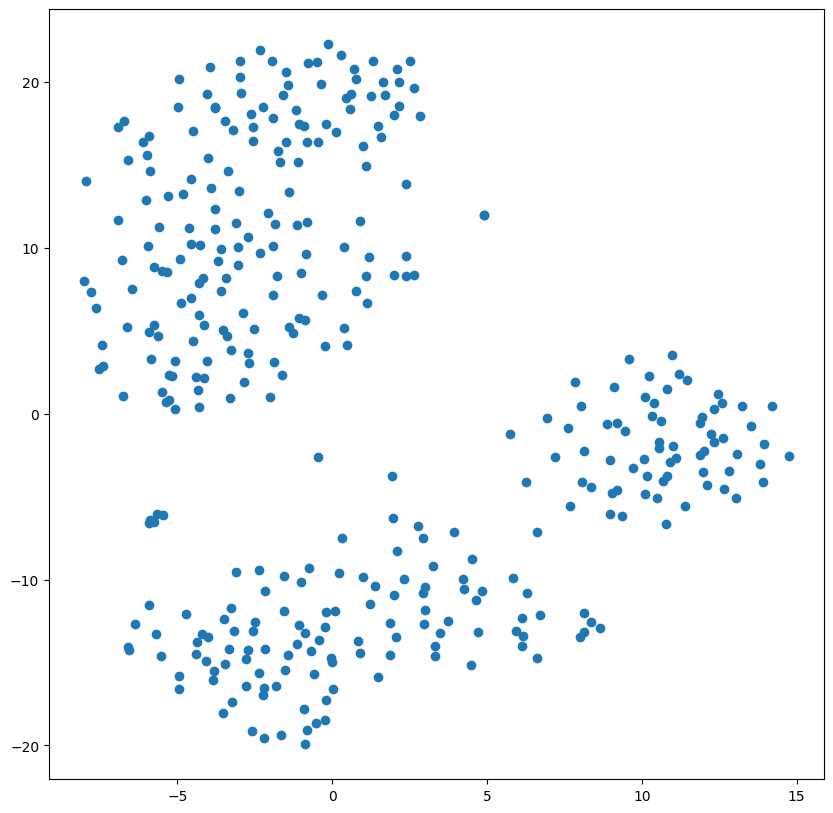

In [2]:
# TSNEで可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# 特徴量の関係か、コサイン距離が良さげ
tsne = TSNE(n_components=2, random_state=42, metric="cosine")

x_tsne = tsne.fit_transform(x)

plt.figure(figsize=(10, 10))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1])

plt.show()

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering

method = "k"
n_clusters = 4

if method == "k":
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
elif method == "a":
    model = AgglomerativeClustering(n_clusters=n_clusters)

y_predict = model.fit_predict(x)

上は直接生のベクトルでクラスタリングしてますが、次のようにt-SNEで図のように2次元に削減したものをクラスタリングしたほうが、識別がきれいに分かれる、ことが多いような気がします、が詳しくは分かりません:

In [6]:
y_predict = model.fit_predict(x_tsne)

In [7]:
centroids = []
for i in range(n_clusters):
    centroids.append(x[y_predict == i].mean(axis=0))

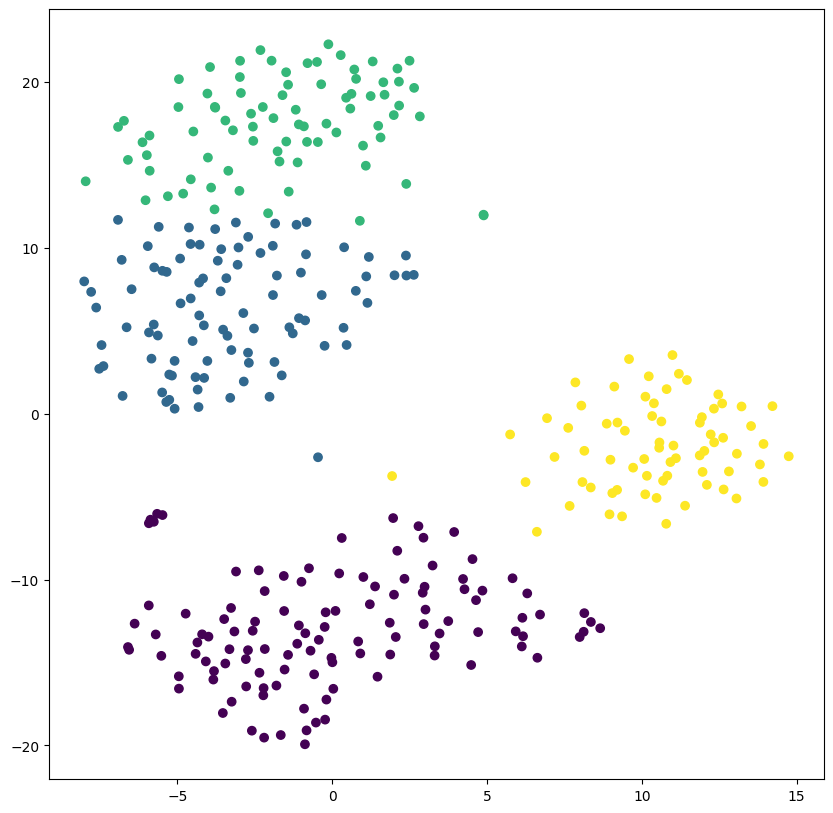

In [8]:
# TSNEで可視化
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_predict)

plt.show()

In [9]:
from scipy.spatial.distance import cdist
from IPython.display import Audio, display

# 各クラスターのセントロイドに最も近い点に対応するファイル名を取得
closest_files = []
for center_idx in range(len(centroids)):
    closest_idx = np.argmin(
        cdist(centroids[center_idx : center_idx + 1], x, metric="cosine")
    )
    closest_files.append(names[closest_idx])

# 対応する音声ファイルをJupyterノートブック上で再生
for file_name in closest_files:
    wav_path = os.path.join(wav_dir, file_name.replace(".npy", ""))
    if os.path.exists(wav_path):
        print(wav_path)
        display(Audio(wav_path))

In [37]:
# meanとcentroidを保存
mean = x.mean(axis=0)
save_vectors = np.vstack([mean, centroids])
os.makedirs("model_assets/jvnv-M1", exist_ok=True)
np.save("model_assets/jvnv-M1/style_vectors.npy", save_vectors)

In [10]:
# JVNVコーパスの場合は正解はファイル名の最初の方から分かる。それを使って正解ラベルを作成
y_true = [name[3:6] for name in names]

for i, y in enumerate(y_true):
    if y == "ang":
        y_true[i] = 0
    elif y == "dis":
        y_true[i] = 1
    elif y == "fea":
        y_true[i] = 2
    elif y == "hap":
        y_true[i] = 3
    elif y == "sad":
        y_true[i] = 4
    elif y == "sur":
        y_true[i] = 5
    else:
        print(y)
        raise ValueError

In [12]:
# 正解のセントロイドを計算
y_true = np.array(y_true)
true_centroids = []
for i in range(6):
    true_centroids.append(np.mean(x[y_true == i], axis=0))

true_centroids = np.array(true_centroids)

# すべてのベクトルの平均を計算
mean = np.mean(x, axis=0)

# 保存
os.makedirs("model_assets/jvnv-M1", exist_ok=True)
np.save("model_assets/jvnv-M1/style_vectors.npy", np.vstack([mean, true_centroids]))

In [7]:
# 正解のメドイドを計算
from sklearn.metrics.pairwise import pairwise_distances

medoids = []
for i in range(6):
    dist = pairwise_distances(x[y_true == i])
    medoid = np.argmin(np.sum(dist, axis=0))
    medoids.append(x[y_true == i][medoid])

medoids = np.array(medoids)

# np.save("model_assets/jvnv-F2/xvectors.npy", np.vstack([mean, medoids]))
# メドイドよりもセントロイドがいいかも？


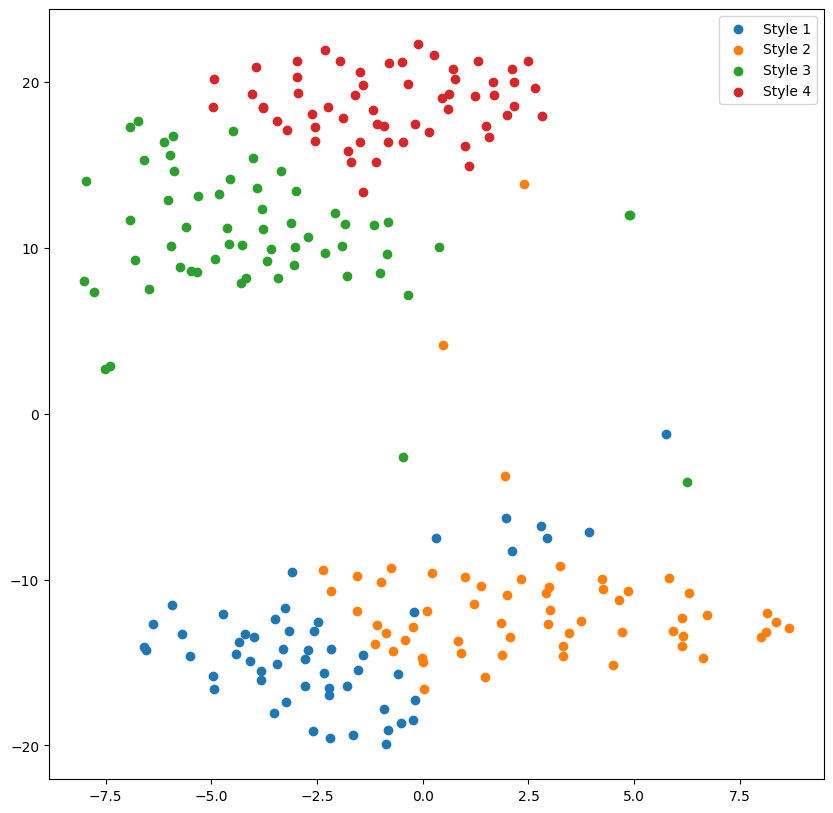

In [15]:
# TSNEで可視化
import matplotlib.pyplot as plt

cmap = plt.get_cmap("tab10")

true_label_dict = {0: "ang", 1: "dis", 2: "fea", 3: "hap", 4: "sad", 5: "sur"}

plt.figure(figsize=(10, 10))
for i in range(n_clusters):
    plt.scatter(
        x_tsne[y_true == i, 0],
        x_tsne[y_true == i, 1],
        color=cmap(i),
        label=f"Style {i+1}",
    )
plt.legend()
plt.show()